In [35]:
import sys
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

from datetime import datetime, timedelta
import os

import matplotlib.pyplot as plt

def getMeanAndStdDev(ds, timeWindow):
    TAO_TIME = np.array(ds['TAO_TIME'].to_numpy(), dtype='datetime64[ns]')[0,:]
    TRMM_TIME = np.array(ds['TRMM_TIME'].to_numpy(), dtype='datetime64[ns]')
    mask = np.isnat(TAO_TIME)
    ds = ds.isel(TRMM_TIME=0)
    ds = ds.isel(TAO_TIME_INDEX = ~mask)
    TAO_TIME = np.array(ds['TAO_TIME'].to_numpy(), dtype='datetime64[ns]')
    timeDiffInMins = np.array(TAO_TIME - TRMM_TIME, dtype='timedelta64[s]')/60
    absTimeDiffInMins = np.array(abs(timeDiffInMins), dtype=np.float32)
    mask = absTimeDiffInMins <= timeWindow/2
    mask = np.logical_and(mask, ds.sel(HEIGHT=4)['WSPD_QC'].isin([1,2]).to_numpy())
    mask = np.logical_and(mask, ds.sel(HEIGHT=4)['WDIR_QC'].isin([1,2]).to_numpy())
    mask = np.logical_and(mask, ds.sel(DEPTH=1)['SST_QC'].isin([1,2]).to_numpy())
    mask = np.logical_and(mask, ds.sel(HEIGHT=3)['AIRT_QC'].isin([1,2]).to_numpy())
    mask = np.logical_and(mask, ds.sel(HEIGHT=3)['RELH_QC'].isin([1,2]).to_numpy())
    
    sel_WSPD = ds.sel(HEIGHT = 4.0)['WSPD'].to_numpy()[mask]
    sel_WSPD_10N = ds.sel(HEIGHT = 10.0)['WSPD_10N'].to_numpy()[mask]
    sel_WDIR = ds.sel(HEIGHT = 4.0)['WDIR'].to_numpy()[mask]

    sel_Ux_10N = sel_WSPD_10N * np.cos(np.deg2rad((-(sel_WDIR - 90.0) + 360)%360))
    sel_Vy_10N = sel_WSPD_10N * np.sin(np.deg2rad((-(sel_WDIR - 90.0) + 360)%360))

    sel_cosWDIR = np.cos(np.deg2rad((-(sel_WDIR - 90.0) + 360)%360))
    sel_sinWDIR = np.sin(np.deg2rad((-(sel_WDIR - 90.0) + 360)%360))

    if np.sum(mask) > 0:
        stdWSPD = np.nanstd(sel_WSPD)
        meanWSPD = np.nanmean(sel_WSPD)

        stdWSPD_10N = np.nanstd(sel_WSPD_10N)
        meanWSPD_10N = np.nanmean(sel_WSPD_10N)

        stdUx_10N = np.nanstd(sel_Ux_10N)
        meanUx_10N = np.nanmean(sel_Ux_10N)

        stdVy_10N = np.nanstd(sel_Vy_10N)
        meanVy_10N = np.nanmean(sel_Vy_10N)
    
        stdWDIR = np.nanstd(sel_WDIR)
        meanWDIR = np.nanmean(sel_WDIR)

        stdCosWDIR = np.nanstd(sel_cosWDIR)
        meanCosWDIR = np.nanmean(sel_cosWDIR)

        stdSinWDIR = np.nanstd(sel_sinWDIR)
        meanSinWDIR = np.nanmean(sel_sinWDIR)
    else:
        stdWSPD = np.nan
        meanWSPD = np.nan

        stdWSPD_10N = np.nan
        meanWSPD_10N = np.nan

        stdUx_10N = np.nan
        meanUx_10N = np.nan

        stdVy_10N = np.nan
        meanVy_10N = np.nan
    
        stdWDIR = np.nan
        meanWDIR = np.nan

        stdCosWDIR = np.nan
        meanCosWDIR = np.nan

        stdSinWDIR = np.nan
        meanSinWDIR = np.nan
    
    return meanWSPD, stdWSPD, meanWSPD_10N, stdWSPD_10N, stdUx_10N, meanUx_10N, stdVy_10N, meanVy_10N, meanWDIR, stdWDIR, meanCosWDIR, stdCosWDIR, meanSinWDIR, stdSinWDIR

def makeMeanAndStdXarrVars(dummyDS, timeWindowInMins):
    meanWSPD, stdWSPD, meanWSPD_10N, stdWSPD_10N, stdUx_10N, meanUx_10N, stdVy_10N, meanVy_10N, meanWDIR, stdWDIR, meanCosWDIR, stdCosWDIR, meanSinWDIR, stdSinWDIR = getMeanAndStdDev(dummyDS, timeWindowInMins)

    dummyDS[f'mean WSPD {timeWindowInMins:d}min'] = xr.DataArray([meanWSPD], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered mean'})
    dummyDS[f'std. dev. WSPD {timeWindowInMins:d}min'] = xr.DataArray([stdWSPD], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered std. dev.'})
    
    dummyDS[f'mean WSPD_10N {timeWindowInMins:d}min'] = xr.DataArray([meanWSPD_10N], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered mean'})
    dummyDS[f'std. dev. WSPD_10N {timeWindowInMins:d}min'] = xr.DataArray([stdWSPD_10N], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered std. dev.'})
    
    dummyDS[f'mean Ux_10N {timeWindowInMins:d}min'] = xr.DataArray([meanUx_10N], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered mean'})
    dummyDS[f'std. dev. Ux_10N {timeWindowInMins:d}min'] = xr.DataArray([stdUx_10N], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered std. dev.'})
    
    dummyDS[f'mean Vy_10N {timeWindowInMins:d}min'] = xr.DataArray([meanVy_10N], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered mean'})
    dummyDS[f'std. dev. Vy_10N {timeWindowInMins:d}min'] = xr.DataArray([stdVy_10N], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'm/s', 'long_name': f'{timeWindowInMins} min centered std. dev.'})
    
    dummyDS[f'mean WDIR {timeWindowInMins:d}min'] = xr.DataArray([meanWDIR], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'degrees (True)', 'long_name': f'{timeWindowInMins} min centered mean'})
    dummyDS[f'std. dev. WDIR {timeWindowInMins:d}min'] = xr.DataArray([stdWDIR], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : 'degrees (True)', 'long_name': f'{timeWindowInMins} min centered std. dev'})
    
    dummyDS[f'mean cosWDIR {timeWindowInMins:d}min'] = xr.DataArray([meanCosWDIR], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : '', 'long_name': f'{timeWindowInMins} min centered mean'})
    dummyDS[f'std. dev. cosWDIR {timeWindowInMins:d}min'] = xr.DataArray([stdCosWDIR], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : '', 'long_name': f'{timeWindowInMins} min centered std. dev'})
    
    dummyDS[f'mean sinWDIR {timeWindowInMins:d}min'] = xr.DataArray([meanSinWDIR], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : '', 'long_name': f'{timeWindowInMins} min centered mean'})
    dummyDS[f'std. dev. sinWDIR {timeWindowInMins:d}min'] = xr.DataArray([stdSinWDIR], dims = ['TRMM_TIME'], 
                                                attrs = {'units' : '', 'long_name': f'{timeWindowInMins} min centered std. dev'})
    return dummyDS


def converttoDatetimeList(ds, timeVar='TIME'):
    timeArr = ds[timeVar].to_numpy()
    tval = pd.to_datetime(timeArr)
    timeSeries = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in tval])
    ds['TIME'] = timeSeries
    return ds


def selectMatchingTime(ds_TRMM, ds_TAO, timeVar1 = 'TIME', timeVar2='TIME'):

    ds_TRMM = ds_TRMM.rename({timeVar1: 'TRMM_TIME'})
    ds_TAO = ds_TAO.rename({timeVar2: 'TAO_TIME'})

    ds_TRMM = ds_TRMM.sortby('TRMM_TIME')
    ds_TAO = ds_TAO.sortby('TAO_TIME')

    lat = ds_TAO['LATITUDE'].to_numpy()
    lon = ds_TAO['LONGITUDE'].to_numpy()

    ds_TAO = ds_TAO.drop('LATITUDE')
    ds_TAO = ds_TAO.drop('LONGITUDE')
    
    time1 = ds_TRMM['TRMM_TIME'].to_numpy()
    time2 = ds_TAO['TAO_TIME'].to_numpy()

    tlen1 = len(time1)
    tlen2 = len(time2)

    i = 0 
    j = 0
    loop = True
    indices = []
    count = 0
    while loop:# or count < 500:
        count += 1
        #print(time1[i],time2[j], np.array(abs(time1[i]- time2[j]), dtype='timedelta64[s]'))
        if np.array(abs(time1[i]- time2[j]), dtype='timedelta64[s]') < 600:
            #print('A')
            indices.append([i,j])
            i+=1
            j+=1
        elif time1[i] < time2[j]:
            i+=1
        else:
            j+=1
        
        if i == len(time1) or j==len(time2):
            loop = False
            
    indices = np.array(indices, dtype=int)
    print(indices.shape)
    if len(indices) == 0:
        print(f'none matched in lat:{lat} and lon:{lon}')
        sel_ds_TRMM = xr.Dataset()
        sel_ds_TAO = xr.Dataset()
        return sel_ds_TRMM, sel_ds_TAO
    else:
        print(f'{len(indices)} matched in lat:{lat} and lon:{lon}')
        # MPI.Finalize()
        # sys.exit()

    sel_ds_TRMM = ds_TRMM.isel(TRMM_TIME = indices[:,0])
    
    # sel_ds_TAO = ds_TAO.isel(TAO_TIME = indices[:,1])
    # TAO_TIME = sel_ds_TAO['TAO_TIME'].to_numpy()
    # sel_ds_TAO = sel_ds_TAO.rename({'TAO_TIME':'TRMM_TIME'})
    # sel_ds_TAO['TRMM_TIME'] = sel_ds_TRMM['TRMM_TIME'].to_numpy()
    # sel_ds_TAO['TAO_TIME'] = xr.DataArray(TAO_TIME, dims=['TRMM_TIME'])

    sel_ds_TAO = xr.Dataset()
    
    buoyIndices = indices[:,1]
    satIndices = indices[:,0]
    selBuoyDS = []
    for indxCount in range(len(buoyIndices)):
        # if indxCount%100 == 0: 
        #     print(f'In rank {rank}: {indxCount/len(buoyIndices) * 100:5.2f} complete')
        buoyIndex = buoyIndices[indxCount]
        satIndex = satIndices[indxCount]
        #print(buoyIndex, satIndex)
        startIndex = buoyIndex - 6
        endIndex = buoyIndex + 7
        if startIndex < 0:
            startIndex = 0
        if endIndex > tlen2:
            endIndex = tlen2
        dummyDS = ds_TAO.isel(TAO_TIME = slice(startIndex,endIndex))
        dummyLen = endIndex - startIndex

        TAO_time = dummyDS['TAO_TIME'].to_numpy()
        dummyDS = dummyDS.rename({'TAO_TIME':'TAO_TIME_INDEX'})
        dummyDS['TAO_TIME_INDEX'] = xr.DataArray(np.arange(startIndex, endIndex) - buoyIndex,
                                           dims=['TAO_TIME_INDEX'])
        
        dummyDS['TAO_TIME'] = xr.DataArray(TAO_time, dims=['TAO_TIME_INDEX'])
        #print(ds_TRMM.TRMM_TIME.shape)
        dummyTime = ds_TRMM.isel(TRMM_TIME = [satIndex])['TRMM_TIME']#.to_numpy()
        #tval = pd.to_datetime(dummyTime)
        #dummyTime = datetime(tval.year, tval.month, tval.day, tval.hour, tval.minute, tval.second)
        dummyDS = dummyDS.expand_dims({'TRMM_TIME' : dummyTime}) 

        ## Calculating Mean and Std. Dev ##
        
        for timeWindowInMins in range(20,130,10):
            dummyDS = makeMeanAndStdXarrVars(dummyDS, timeWindowInMins)
        


        selBuoyDS.append(dummyDS)
        # if indxCount == 0 :
        #     sel_ds_TAO = dummyDS
        # else:
        #     sel_ds_TAO = xr.concat([sel_ds_TAO, dummyDS], dim='TRMM_TIME' )
    sel_ds_TAO = xr.concat(selBuoyDS, dim='TRMM_TIME')
    
    return sel_ds_TRMM, sel_ds_TAO


In [36]:
lat = -2
lon = -110

if lat < 0:
    latUnits = 'S'
else:
    latUnits = 'N'

if lon < 0:
    lonUnits = 'W'
else:
    lonUnits = 'E'

lat=abs(lat)
lon=abs(lon)

bFile = f'../../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_xrr_COARE3p5_2000.nc'
satFile = f'../../../downloads/TRMM_data/TRMM_byTAOpos/TAOpos_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_TRMM.nc'

ds_Buoy = xr.open_dataset(bFile)
ds_Sat = xr.open_dataset(satFile)

ds_Buoy = ds_Buoy.sortby('TIME')
ds_Sat = ds_Sat.sortby('time')

ds_Buoy = converttoDatetimeList(ds_Buoy)#, timeVar='TIME')
ds_Sat = converttoDatetimeList(ds_Sat, timeVar='time')

ds_TRMM, ds_TAO = selectMatchingTime(ds_Sat, ds_Buoy, timeVar1='time')
    

(748, 2)
748 matched in lat:[-2.] and lon:[-110.]


In [37]:
ds_Buoy

<xarray.Dataset>
Dimensions:    (TIME: 156707, HEIGHT: 3, LATITUDE: 1, LONGITUDE: 1, DEPTH: 1)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2001-01-01 ... 2005-11-16T16:20:00
  * HEIGHT     (HEIGHT) float32 3.0 4.0 10.0
  * LATITUDE   (LATITUDE) float32 -2.0
  * LONGITUDE  (LONGITUDE) float32 -110.0
  * DEPTH      (DEPTH) float32 1.0
Data variables: (12/19)
    WDIR       (TIME, HEIGHT) float32 ...
    WDIR_QC    (TIME, HEIGHT) float32 ...
    WDIR_DM    (TIME, HEIGHT) |S1 ...
    WSPD       (TIME, HEIGHT) float32 ...
    WSPD_QC    (TIME, HEIGHT) float32 ...
    WSPD_DM    (TIME, HEIGHT) |S1 ...
    ...         ...
    AIRT_DM    (TIME, HEIGHT) |S1 ...
    RELH       (TIME, HEIGHT) float32 ...
    RELH_QC    (TIME, HEIGHT) float32 ...
    RELH_DM    (TIME, HEIGHT) |S1 ...
    WSPD_10N   (TIME, HEIGHT) float64 ...
    WSPD_10    (TIME, HEIGHT) float64 ...
Attributes: (12/43)
    time_coverage_start:           2000-10-28T07:50:00
    time_coverage_end:             2001-01-01T23:50:00
    featureType:                   timeSeries
    format_version:                1.3
    platform_code:                 T2S110W
    platform_type:                 ATLAS
    ...                            ...
    publisher_name:                NDBC Webmaster
    publisher_email:               webmaster.ndbc@noaa.gov
    date_created:                  2023-09-15T14:52:49Z
    date_modified:                 2023-09-15T14:52:49Z
    processing_level:              Data manually reviewed
    history:                       2023-09-15T14:52:49Z subset data extracted...

In [38]:
ds_Sat

<xarray.Dataset>
Dimensions:       (time: 5803, nray: 6, fakeDim8: 2, ncell1: 80, TIME: 5803)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-03T04:58:41.000296 ... 2007-0...
  * nray          (nray) int64 0 1 2 3 4 5
  * fakeDim8      (fakeDim8) int64 0 1
  * ncell1        (ncell1) int64 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
  * TIME          (TIME) datetime64[ns] 2000-01-03T04:58:41 ... 2007-01-01T10...
Data variables:
    nearSurfRain  (time, nray) float64 ...
    e_SurfRain    (time, nray) float64 ...
    rainAve       (time, nray, fakeDim8) float64 ...
    rainFlag      (time, nray) float64 ...
    rainType      (time, nray) float64 ...
    rain          (time, nray, ncell1) float64 ...
    Latitude      (time, nray) float64 ...
    Longitude     (time, nray) float64 ...

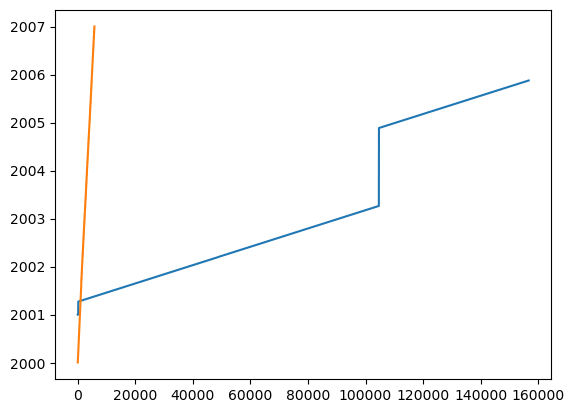

In [39]:

plt.plot(ds_Buoy['TIME'])
plt.plot(ds_Sat['time'])